#importing neccessary libraries...

In [85]:
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

In [86]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the data

First, I uploaded all the data to my google drive and stored it in pandas dataframe.

In [87]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TIMSS2019.xlsx')

In [88]:
df

IDCNTRY  IDBOOK  IDSCHOOL  IDCLASS    IDSTUD finalscore  totalscore  \
0         364       1      5001   500104  50010404          D        14.0   
1         364       1      5001   500104  50010418          D        11.0   
2         364       1      5001   500104  50010432          B        31.0   
3         364       1      5002   500201  50020114          E         6.0   
4         364       1      5002   500201  50020128          D        15.0   
...       ...     ...       ...      ...       ...        ...         ...   
5975      364      14      5218   521801  52180101          D        16.0   
5976      364      14      5219   521901  52190109          D         9.0   
5977      364      14      5219   521901  52190123          E         7.0   
5978      364      14      5220   522001  52200113          D         9.0   
5979      364      14      5220   522001  52200127          E         4.0   

     finalscorealgebra finalscoredat finalscoregeo  ... BTBM23  BTDGEAS  \
0                    A             D             E  ...      5        3   
1                    D             D             E  ...      5        3   
2                    B             D             C  ...      5        3   
3                    D             E             E  ...      4        2   
4                    D             C             E  ...      4        2   
...                ...           ...           ...  ...    ...      ...   
5975                 D             D             D  ...      2        3   
5976                 E             E             C  ...      5        3   
5977                 E             E             D  ...      5        3   
5978                 E             E             C  ...      4        3   
5979                 E             D             E  ...      4        3   

      BTDGLSN  BTDGSOS  BTDGTJS  BTDMMME  BTDMNUM   BTDMALG    BTDMGEO  \
0           2        1        1        2    100.0  28.57143   83.33333   
1           2        1        1        2    100.0  28.57143   83.33333   
2           2        1        1        2    100.0  28.57143   83.33333   
3           2        2        2        3    100.0  28.57143   83.33333   
4           2        2        2        3    100.0  28.57143   83.33333   
...       ...      ...      ...      ...      ...       ...        ...   
5975        3        1        1        2    100.0  28.57143  100.00000   
5976        2        2        1        2    100.0  71.42857  100.00000   
5977        2        2        1        2    100.0  71.42857  100.00000   
5978        3        2        3        2    100.0  14.28571   83.33333   
5979        3        2        3        2    100.0  14.28571   83.33333   

       BTDMDAT  
0     83.33333  
1     83.33333  
2     83.33333  
3     16.66667  
4     16.66667  
...        ...  
5975  83.33333  
5976  83.33333  
5977  83.33333  
5978  66.66667  
5979  66.66667  

[5980 rows x 338 columns]

#Cleaning Dataframe...

 All data must be related to Iranian students. So, we have checked that IDCNTRY is 364.
 Also We should not have duplicate students, so we have removed duplicate IDSTDs.
 For many analyzes and subsequent steps such as XGBoost, the entire dataframe should consist of numbers.
 So instead of A grades, we put 5 and instead of B grades, 4 and... instead of E, we put 1 so that the best grade is the highest.

first, we check everyone to be iranian:

In [89]:
clean_df = df.query('IDCNTRY==364')

second, we try to remove redundant students.

if there is one, we keep the last record of him/her.

In [90]:
clean_df = clean_df.drop_duplicates(subset=['IDSTUD'], keep='last')

third ,we replace grades with numbers:

In [91]:
clean_df = clean_df.replace(['A', 'B', 'C', 'D', 'E'], [5, 4, 3, 2, 1])

##Extra columns

 First, we see the different column values.We do not need ID column for our analysis. So we have removed all of them.
Also, the totalscore and notebook number are not important to us, because according to the explanation given, the finalscore is calculated based on the totalscore and the overall score of the answered notebook. So we can also delete these two columns.
Also Two of the columns are all Nan and no value is recorded for them. (BSDGSEC and
BSBGSEC) 

In [92]:
clean_df = clean_df.drop(columns=['IDSTUD', 'IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDBOOK', 'totalscore', 'BSBGSEC', 'BSDGSEC'])

Also: Columns that have a very high correlation, that is, for example above 0.6, if it is not among the scores, we keep only one. Because in fact, those two variables are completely dependent on each other and sometimes convey the same concept.

In [93]:
def extra():
  extras = []
  for c in clean_df.corr(method ='spearman').columns:
   if c not in (['finalscore', 'finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'] + extras):
    t = clean_df.corr(method ='spearman')[c]
    t = t[abs(t) >= 0.6]
    t = t[t.index != c]
    for extra_col in list(t.index):
      if extra_col not in extras:
        extras.append(extra_col)
   return extras

In [94]:
clean_df = clean_df.drop(columns=extra())
clean_df

finalscore  finalscorealgebra  finalscoredat  finalscoregeo  \
0            2.0                5.0            2.0            1.0   
1            2.0                2.0            2.0            1.0   
2            4.0                4.0            2.0            3.0   
3            1.0                2.0            1.0            1.0   
4            2.0                2.0            3.0            1.0   
...          ...                ...            ...            ...   
5975         2.0                2.0            2.0            2.0   
5976         2.0                1.0            1.0            3.0   
5977         1.0                1.0            1.0            2.0   
5978         2.0                1.0            1.0            3.0   
5979         1.0                1.0            2.0            1.0   

      finalscorenum  BSBG01  BSBG03  BSBG04  BSBG05A  BSBG05B  ...  BTBM23  \
0               1.0     1.0     2.0     3.0      1.0      1.0  ...       5   
1               2.0     1.0     1.0     3.0      1.0      1.0  ...       5   
2               4.0     1.0     1.0     4.0      1.0      1.0  ...       5   
3               1.0     1.0     1.0     2.0      2.0      2.0  ...       4   
4               2.0     1.0     1.0     2.0      1.0      1.0  ...       4   
...             ...     ...     ...     ...      ...      ...  ...     ...   
5975            2.0     2.0     2.0     2.0      2.0      2.0  ...       2   
5976            1.0     1.0     4.0     1.0      2.0      1.0  ...       5   
5977            1.0     1.0     3.0     2.0      1.0      2.0  ...       5   
5978            1.0     2.0     1.0     5.0      1.0      1.0  ...       4   
5979            1.0     2.0     3.0     5.0      2.0      1.0  ...       4   

      BTDGEAS  BTDGLSN  BTDGSOS  BTDGTJS  BTDMMME  BTDMNUM   BTDMALG  \
0           3        2        1        1        2    100.0  28.57143   
1           3        2        1        1        2    100.0  28.57143   
2           3        2        1        1        2    100.0  28.57143   
3           2        2        2        2        3    100.0  28.57143   
4           2        2        2        2        3    100.0  28.57143   
...       ...      ...      ...      ...      ...      ...       ...   
5975        3        3        1        1        2    100.0  28.57143   
5976        3        2        2        1        2    100.0  71.42857   
5977        3        2        2        1        2    100.0  71.42857   
5978        3        3        2        3        2    100.0  14.28571   
5979        3        3        2        3        2    100.0  14.28571   

        BTDMGEO   BTDMDAT  
0      83.33333  83.33333  
1      83.33333  83.33333  
2      83.33333  83.33333  
3      83.33333  16.66667  
4      83.33333  16.66667  
...         ...       ...  
5975  100.00000  83.33333  
5976  100.00000  83.33333  
5977  100.00000  83.33333  
5978   83.33333  66.66667  
5979   83.33333  66.66667  

[5980 rows x 330 columns]

##null values



scores are very important for our analysis. so if we have a record with null final score in each concept, we have to drop that record.

In [95]:
clean_df = clean_df.dropna(subset=['finalscore', 'finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'])

In [96]:
clean_df = clean_df.dropna()

# Normalization

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different ranges.

z_score normalization refers to the process of normalizing each value in a data set so that the mean of all values is 0 and the standard deviation is 1. This allows the data manager to understand the probability of a score occurring in the normal distribution of the data. A z-score enables the data manager to compare two different scores from different normal distributions of data.

Here, the function we have implemented takes a dataframe, iterates all the columns and applies the normalization formula on each of the columns. Finally, it returns the new dataframe.

In [97]:
def z_score(df):
    normalized_df = df.copy()
    for column in normalized_df.columns:
      normalized_df[column]=(normalized_df[column] - normalized_df[column].mean())/normalized_df[column].std()     
    return normalized_df

# XGBoost Classifier

XGBoost is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems. machine learning concepts and algorithms that XGBoost builds upon: supervised machine learning, decision trees, ensemble learning, and gradient boosting.Supervised machine learning uses algorithms to train a model to find patterns in a dataset with labels and features and then uses the trained model to predict the labels on a new dataset’s features.Decision trees create a model that predicts the label by evaluating a tree of if-then-else true/false feature questions, and estimating the minimum number of questions needed to assess the probability of making a correct decision. Decision trees can be used for classification to predict a category, or regression to predict a continuous numeric value.A Gradient Boosting Decision Trees (GBDT) is a decision tree ensemble learning algorithm similar to random forest, for classification and regression. Ensemble learning algorithms combine multiple machine learning algorithms to obtain a better model.XGBDT build a model consisting of multiple decision trees.


 In the XGBClassifier function, we take a dataframe with the destination column and a number of columns that should not be checked in the tree.
 First, we have to remove the features that have more than 8 or less than 2 different values from the analysis. Because they create errors in the decision tree and make it meaningless.
 Leaving aside these features, as well as features such as other grades that are obviously effective in the finalscore, but their impact is not important to us, we make the input X.
 We leave the input y for the feature under review, which is finalscore in the first two questions and 4 other scores in the third question.
 In this way, we  form the decision tree based on x and y. Then we use it for dimension reduction. Because as we know, 300 columns is a lot, and many of them do not have a significant effect on the feature we are considering. So we have returned 30 effective attributes (30 decision tree depth) as a best_attributes list.
 Also, we should not exclude the features that we left out due to high distinct values from our analysis. Because they are all scale types and have different values, by putting them in correlation, we can understand their relationship with the destination feature. So, we have returned lists containing the best variables along with the variables that we removed from the decision tree.

In [98]:

# check xgboost version
import xgboost
print(xgboost.__version__)

0.90


In [99]:
from xgboost import XGBClassifier , plot_tree

def xgbClassifier(df, dest_col,useless_cols):

    t=df.nunique().sort_values(ascending=False)
    t=t[t>8]
    not_uniques=list(t.keys())
    # print("\nfeatures that are useless", not_uniques)

    y = df[dest_col]
    X = df.drop(columns = not_uniques+[dest_col]+useless_cols)
    print(X.nunique().sort_values(ascending=False))


    # define the model
    xg = XGBClassifier(max_depth = 5)
    #fit the model
    xg.fit(X, y)

    
    # important = xg.feature_importances_
    # # summarize feature importance
    # for i,v in enumerate(important):
    #   print('Feature: %0d, Score: %.5f' % (i,v))
    # # plot feature importance
    # plt.bar([x for x in range(len(important))], important)
    # plt.show()

    plot_tree(xg, num_trees=4) 
    plt.show()

 
    print("\n useful features")
    best_attributes = pd.DataFrame(xg.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False).head(30)
    print(best_attributes)


    return not_uniques , list(best_attributes.index)
   


# Spearman Correlation

After these preprocessing steps, we have clean data:

In [100]:
clean_df

finalscore  finalscorealgebra  finalscoredat  finalscoregeo  \
0            2.0                5.0            2.0            1.0   
1            2.0                2.0            2.0            1.0   
2            4.0                4.0            2.0            3.0   
3            1.0                2.0            1.0            1.0   
4            2.0                2.0            3.0            1.0   
...          ...                ...            ...            ...   
5975         2.0                2.0            2.0            2.0   
5976         2.0                1.0            1.0            3.0   
5977         1.0                1.0            1.0            2.0   
5978         2.0                1.0            1.0            3.0   
5979         1.0                1.0            2.0            1.0   

      finalscorenum  BSBG01  BSBG03  BSBG04  BSBG05A  BSBG05B  ...  BTBM23  \
0               1.0     1.0     2.0     3.0      1.0      1.0  ...       5   
1               2.0     1.0     1.0     3.0      1.0      1.0  ...       5   
2               4.0     1.0     1.0     4.0      1.0      1.0  ...       5   
3               1.0     1.0     1.0     2.0      2.0      2.0  ...       4   
4               2.0     1.0     1.0     2.0      1.0      1.0  ...       4   
...             ...     ...     ...     ...      ...      ...  ...     ...   
5975            2.0     2.0     2.0     2.0      2.0      2.0  ...       2   
5976            1.0     1.0     4.0     1.0      2.0      1.0  ...       5   
5977            1.0     1.0     3.0     2.0      1.0      2.0  ...       5   
5978            1.0     2.0     1.0     5.0      1.0      1.0  ...       4   
5979            1.0     2.0     3.0     5.0      2.0      1.0  ...       4   

      BTDGEAS  BTDGLSN  BTDGSOS  BTDGTJS  BTDMMME  BTDMNUM   BTDMALG  \
0           3        2        1        1        2    100.0  28.57143   
1           3        2        1        1        2    100.0  28.57143   
2           3        2        1        1        2    100.0  28.57143   
3           2        2        2        2        3    100.0  28.57143   
4           2        2        2        2        3    100.0  28.57143   
...       ...      ...      ...      ...      ...      ...       ...   
5975        3        3        1        1        2    100.0  28.57143   
5976        3        2        2        1        2    100.0  71.42857   
5977        3        2        2        1        2    100.0  71.42857   
5978        3        3        2        3        2    100.0  14.28571   
5979        3        3        2        3        2    100.0  14.28571   

        BTDMGEO   BTDMDAT  
0      83.33333  83.33333  
1      83.33333  83.33333  
2      83.33333  83.33333  
3      83.33333  16.66667  
4      83.33333  16.66667  
...         ...       ...  
5975  100.00000  83.33333  
5976  100.00000  83.33333  
5977  100.00000  83.33333  
5978   83.33333  66.66667  
5979   83.33333  66.66667  

[5931 rows x 330 columns]

The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient,measures the strength and direction of association between two ranked variables.
The Pearson correlation coefficient is computed using raw data values, whereas, the Spearman correlation is calculated from the ranks of individual values. While the Pearson correlation coefficient is a measure of the linear relation between two variables, the Spearman rank correlation coefficient measures the monotonic relation between a pair of variables.so in this section we decide to use spearman correlation beacause we have monotonic relations.

The spr_corr function receives a dataframe with the feature we want. Using the corr( method="spearman") function in pandas, it forms the correlation matrix.
 To form this matrix, we first went through all the columns of the dataframe and put each one into correlation by leaving out problematic values and also normalizing and its correlation coefficient We have calculated with the desired feature (mostly finalscore). but what do we mean by problematic value?


 when the data has a problem , the value 9 or 99 or 999 or 9999 or 99999 or 999999 is recorded for it. First, we checked how many times each column had a problem.We left out the cases that have more than 10% error in the registration because it can cause errors in the analysis. That is, from BCBG21C down.

In [101]:
problems = []
for feature in clean_df.columns:
   problems.append((feature, len(clean_df[clean_df[feature]==9])))

problems.sort(key = lambda x: x[1]) 
problems

[('finalscore', 0),
 ('finalscorealgebra', 0),
 ('finalscoredat', 0),
 ('finalscoregeo', 0),
 ('finalscorenum', 0),
 ('BSBG01', 0),
 ('ITSEX', 0),
 ('BSDAGE', 0),
 ('BSBGHER', 0),
 ('BSBGSSB', 0),
 ('BSBGSB', 0),
 ('BSBGSLM', 0),
 ('BSBGICM', 0),
 ('BSBGDML', 0),
 ('BSBGSCM', 0),
 ('BSBGSVM', 0),
 ('BCBG04', 0),
 ('BCBG05A', 0),
 ('BCBG05B', 0),
 ('BCBG06A', 0),
 ('BCBG06B', 0),
 ('BCBG06C', 0),
 ('BCBG09', 0),
 ('BCBG10A', 0),
 ('BCBG10B', 0),
 ('BCBG12', 0),
 ('BCBG13AA', 0),
 ('BCBG13AE', 0),
 ('BCBG13AG', 0),
 ('BCBG13AH', 0),
 ('BCBG13BA', 0),
 ('BCBG13BB', 0),
 ('BCBG13BC', 0),
 ('BCBG14A', 0),
 ('BCBG14B', 0),
 ('BCBG14C', 0),
 ('BCBG14D', 0),
 ('BCBG14F', 0),
 ('BCBG14G', 0),
 ('BCBG14I', 0),
 ('BCBG14K', 0),
 ('BCBG15A', 0),
 ('BCBG15C', 0),
 ('BCBG15D', 0),
 ('BCBG15G', 0),
 ('BCBG15H', 0),
 ('BCBG16C', 0),
 ('BCBG17A', 0),
 ('BCBG20', 0),
 ('BCDGDAS', 0),
 ('BCDGEAS', 0),
 ('BCDGMRS', 0),
 ('BCDGSRS', 0),
 ('BCDGTIHY', 0),
 ('BTBG02', 0),
 ('BTBG03', 0),
 ('BTBG04', 0),
 ('B

so we drop these columns

In [102]:
clean_df = clean_df.drop(columns=['BSBM27AA', 'BSBM27BA' , 'BCBG21C'])


 We must make sure that the negative and positive numbers returned are completely meaningful, and in fact, in this project, we are looking for the degree of dependence, the higher the absolute value of these numbers, the greater the dependence. And the sign of the number shows us direct or inverse dependence.

In [103]:
def spr_corr(df, dest_col):
  results = []
  for feature in df.columns:
    if feature != dest_col:
      t= df[[dest_col, feature]]
      feature_max = max(t[feature])
      if feature_max in [9, 99, 999, 9999, 99999, 999999]:
        t=t[t[feature]<feature_max]
      t=z_score(t)
      results.append((feature, t.corr(method='spearman')[dest_col][feature]))

  results.sort(key = lambda x: x[1]) 
  return results

show_corr function checks the relationship between two columns. In fact, by receiving a table and the names of two of its columns, it shows the dependence of these two columns. It puts the y input in the vertical axis and the x axis is the x input.

 It divides all the values of the table based on the distinct values of X and plots the average of y in each of the x values in that value.

In [104]:
def show_corr(df, x, y):
  df = df[[x, y]]
  feature_max = max(df[x])
  if feature_max in [9, 99, 999, 9999, 99999, 999999]:
    df = df[df[x]<feature_max]
  df = df.groupby(x).mean()
  print("\n correlation of", y, "and", x,': ')
  df.plot(y = y, kind='line' , color ='darkblue', alpha = 0.3 , marker = '^',figsize=(10, 6))
  plt.show()

#Questions:

#The most important factors on the finalscore

We need the clean df in full in this section because there is no limit. We will remove only 4 score columns except Finalscore because there is usually a lot of dependence between them and we are not looking for it.
 The destination column for all functions in this section is finalscore.
 First, we make an xgboostClassifier and keep only the best features

In [105]:
clean_df

finalscore  finalscorealgebra  finalscoredat  finalscoregeo  \
0            2.0                5.0            2.0            1.0   
1            2.0                2.0            2.0            1.0   
2            4.0                4.0            2.0            3.0   
3            1.0                2.0            1.0            1.0   
4            2.0                2.0            3.0            1.0   
...          ...                ...            ...            ...   
5975         2.0                2.0            2.0            2.0   
5976         2.0                1.0            1.0            3.0   
5977         1.0                1.0            1.0            2.0   
5978         2.0                1.0            1.0            3.0   
5979         1.0                1.0            2.0            1.0   

      finalscorenum  BSBG01  BSBG03  BSBG04  BSBG05A  BSBG05B  ...  BTBM23  \
0               1.0     1.0     2.0     3.0      1.0      1.0  ...       5   
1               2.0     1.0     1.0     3.0      1.0      1.0  ...       5   
2               4.0     1.0     1.0     4.0      1.0      1.0  ...       5   
3               1.0     1.0     1.0     2.0      2.0      2.0  ...       4   
4               2.0     1.0     1.0     2.0      1.0      1.0  ...       4   
...             ...     ...     ...     ...      ...      ...  ...     ...   
5975            2.0     2.0     2.0     2.0      2.0      2.0  ...       2   
5976            1.0     1.0     4.0     1.0      2.0      1.0  ...       5   
5977            1.0     1.0     3.0     2.0      1.0      2.0  ...       5   
5978            1.0     2.0     1.0     5.0      1.0      1.0  ...       4   
5979            1.0     2.0     3.0     5.0      2.0      1.0  ...       4   

      BTDGEAS  BTDGLSN  BTDGSOS  BTDGTJS  BTDMMME  BTDMNUM   BTDMALG  \
0           3        2        1        1        2    100.0  28.57143   
1           3        2        1        1        2    100.0  28.57143   
2           3        2        1        1        2    100.0  28.57143   
3           2        2        2        2        3    100.0  28.57143   
4           2        2        2        2        3    100.0  28.57143   
...       ...      ...      ...      ...      ...      ...       ...   
5975        3        3        1        1        2    100.0  28.57143   
5976        3        2        2        1        2    100.0  71.42857   
5977        3        2        2        1        2    100.0  71.42857   
5978        3        3        2        3        2    100.0  14.28571   
5979        3        3        2        3        2    100.0  14.28571   

        BTDMGEO   BTDMDAT  
0      83.33333  83.33333  
1      83.33333  83.33333  
2      83.33333  83.33333  
3      83.33333  16.66667  
4      83.33333  16.66667  
...         ...       ...  
5975  100.00000  83.33333  
5976  100.00000  83.33333  
5977  100.00000  83.33333  
5978   83.33333  66.66667  
5979   83.33333  66.66667  

[5931 rows x 327 columns]

BTDMGEO     8
BCBG05A     8
BSBM26BA    7
BSBM42BA    7
BSDGEDUP    7
           ..
BTBG05G     2
ITSEX       2
BCBG12      2
BTBG02      2
BSBG01      2
Length: 299, dtype: int64


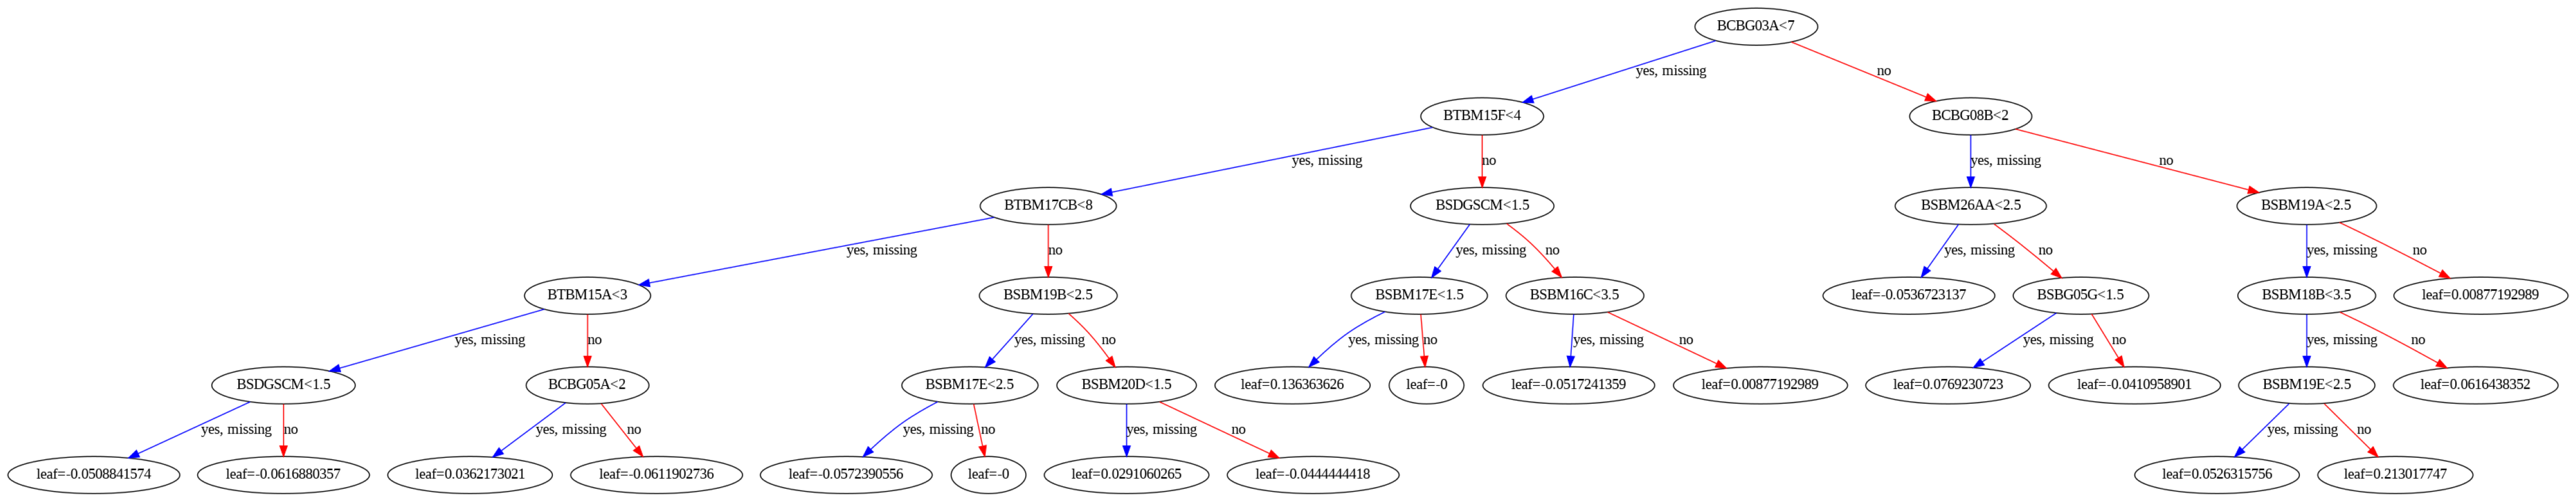


 useful features
          importance
BSBG07      0.017601
BSDGSCM     0.014611
BCDGEAS     0.010978
BCDGSBC     0.009721
BCBG14H     0.009121
BSBG05B     0.009101
BTDGEAS     0.007795
BCBG05B     0.007422
BCBG08B     0.007353
BSBM19B     0.007347
BCBG05A     0.007265
BSBM19H     0.007228
BTDMNUM     0.006408
BTBM19CB    0.006281
BSDGEDUP    0.006063
BCBG14F     0.006010
BTBM17CC    0.006002
BCBG04      0.005865
BSBM19D     0.005803
BSBG04      0.005458
BTBG06E     0.005440
BTBG07G     0.005370
BCBG15G     0.005257
BTBG06F     0.005227
BSBG08B     0.005190
BSBG05D     0.005161
BTBG13A     0.005096
BSBM19I     0.004975
BSBM19A     0.004891
BCBG14G     0.004873


In [106]:
not_uniques, best_attributes = xgbClassifier(clean_df,'finalscore', ['finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'] )                                 
                                                      

Based on the implemented xgboostClassifier, the important features are as follows, sorted by usage in the lowest depth of the tree:

In [107]:
full_df = clean_df[['finalscore'] + best_attributes + not_uniques]


So we create our new table. We can see that we have not removed anything from the rows, but the number of columns has been greatly reduced and we have had a dimension reduction.

And finally, we pass the new table with the destination column to the spr_corr function to find the most dependent features:

In [108]:
spr_corr(full_df, 'finalscore')

[('BSDGSCM', -0.35769782082313983),
 ('BSDGEDUP', -0.32713928776607254),
 ('BSBM19D', -0.3019785744692962),
 ('BSBM19A', -0.271149052110923),
 ('BCDGSBC', -0.26972234918257726),
 ('BCBG05B', -0.2678939195134043),
 ('BCBG05A', -0.2614523591557863),
 ('BCBG14H', -0.2505038081511452),
 ('BCBG14F', -0.24582823293143174),
 ('BTBG06F', -0.23959287480102448),
 ('BSBG05B', -0.2395826655361799),
 ('BTBG06E', -0.22536194568277235),
 ('BCBG14G', -0.22412065759328095),
 ('BCDGEAS', -0.21626913282323237),
 ('BTDGEAS', -0.2018937118723894),
 ('BSBG05D', -0.19750870215205102),
 ('BCBG04', -0.18177816245316775),
 ('BSBG08B', -0.13820513872296297),
 ('BTBG13A', -0.1335239637466675),
 ('BTBG11', -0.10733142631279657),
 ('BSDAGE', -0.05710863337132018),
 ('BCBG15G', -0.054944853233214096),
 ('BTBM17CC', -0.050140001574509235),
 ('BCBG08B', -0.04210243034488947),
 ('BTBG07G', -0.020509167697879263),
 ('BTBM19CB', 0.0020156358963660174),
 ('BTDMDAT', 0.005282577593118247),
 ('BTDMALG', 0.006029140035603907

In [109]:
# plt.barh( A_df z)

By comparing the absolute values, we can say the following 3 very important features to answer this Question:


 correlation of finalscore and BSDGEDUP : 


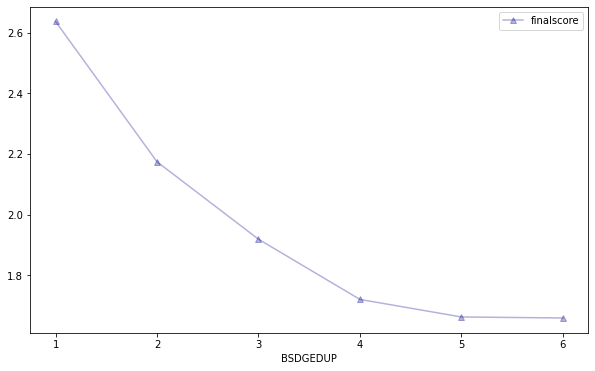


 correlation of finalscore and BSBG04 : 


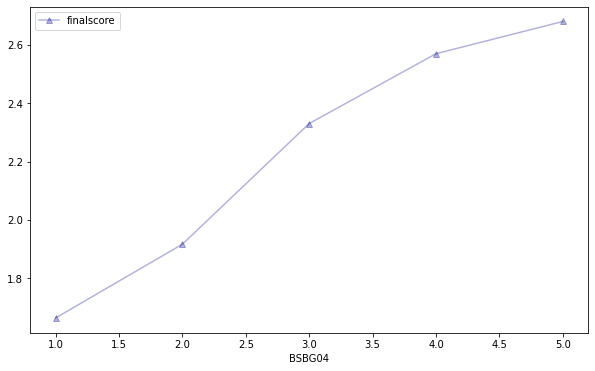


 correlation of finalscore and BSBM19H : 


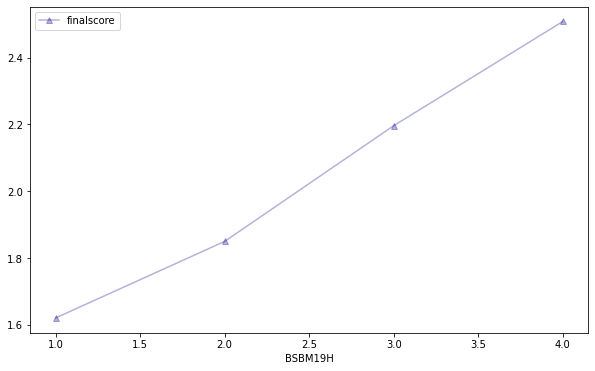

In [110]:
show_corr(clean_df, 'BSDGEDUP', 'finalscore')
show_corr(clean_df, 'BSBG04', 'finalscore')
show_corr(clean_df, 'BSBM19H', 'finalscore')

the relation between finalscore with BSDGEDUP : inverse (Parents' Highest Education Level)

the relation between finalscore with BSBG04 : direct (Home Educational Resources/SCL)

the relation between finalscore with BSBM19H : : direct (Student Confident in Mathematics/SCL)

# Effects of gender in final score

For this section, we easily performed the same steps as in the previous question, this time for two separate tables. which is one for half of the male students and one for half of the female students. We have done this with a query on the gender attribute. And the destination column is the finalscore. The table we make for girls: We can see that the number of lines is almost half as before. Now with the same previous steps, we reach these effective variables:

###Female

We calculate similarly for girls. And we only change the first query.

In [111]:
female_df = clean_df[clean_df['BSBG01']==1]
female_df

finalscore  finalscorealgebra  finalscoredat  finalscoregeo  \
0            2.0                5.0            2.0            1.0   
1            2.0                2.0            2.0            1.0   
2            4.0                4.0            2.0            3.0   
3            1.0                2.0            1.0            1.0   
4            2.0                2.0            3.0            1.0   
...          ...                ...            ...            ...   
5970         1.0                1.0            1.0            2.0   
5973         3.0                3.0            2.0            3.0   
5974         2.0                3.0            2.0            3.0   
5976         2.0                1.0            1.0            3.0   
5977         1.0                1.0            1.0            2.0   

      finalscorenum  BSBG01  BSBG03  BSBG04  BSBG05A  BSBG05B  ...  BTBM23  \
0               1.0     1.0     2.0     3.0      1.0      1.0  ...       5   
1               2.0     1.0     1.0     3.0      1.0      1.0  ...       5   
2               4.0     1.0     1.0     4.0      1.0      1.0  ...       5   
3               1.0     1.0     1.0     2.0      2.0      2.0  ...       4   
4               2.0     1.0     1.0     2.0      1.0      1.0  ...       4   
...             ...     ...     ...     ...      ...      ...  ...     ...   
5970            1.0     1.0     3.0     3.0      1.0      2.0  ...       3   
5973            2.0     1.0     1.0     2.0      1.0      1.0  ...       3   
5974            2.0     1.0     1.0     1.0      1.0      2.0  ...       3   
5976            1.0     1.0     4.0     1.0      2.0      1.0  ...       5   
5977            1.0     1.0     3.0     2.0      1.0      2.0  ...       5   

      BTDGEAS  BTDGLSN  BTDGSOS  BTDGTJS  BTDMMME  BTDMNUM   BTDMALG  \
0           3        2        1        1        2    100.0  28.57143   
1           3        2        1        1        2    100.0  28.57143   
2           3        2        1        1        2    100.0  28.57143   
3           2        2        2        2        3    100.0  28.57143   
4           2        2        2        2        3    100.0  28.57143   
...       ...      ...      ...      ...      ...      ...       ...   
5970        3        3        2        1        2    100.0  28.57143   
5973        3        2        2        1        1    100.0  42.85714   
5974        3        2        2        1        1    100.0  42.85714   
5976        3        2        2        1        2    100.0  71.42857   
5977        3        2        2        1        2    100.0  71.42857   

        BTDMGEO   BTDMDAT  
0      83.33333  83.33333  
1      83.33333  83.33333  
2      83.33333  83.33333  
3      83.33333  16.66667  
4      83.33333  16.66667  
...         ...       ...  
5970  100.00000  50.00000  
5973   66.66667  50.00000  
5974   66.66667  50.00000  
5976  100.00000  83.33333  
5977  100.00000  83.33333  

[2927 rows x 327 columns]

BCBG05A     8
BSBM26BA    7
BSDGEDUP    7
BSBM42BA    7
BSBG07      7
           ..
BTBG05H     2
BTBG05G     2
BTBG05F     2
ITSEX       1
BSBG01      1
Length: 299, dtype: int64


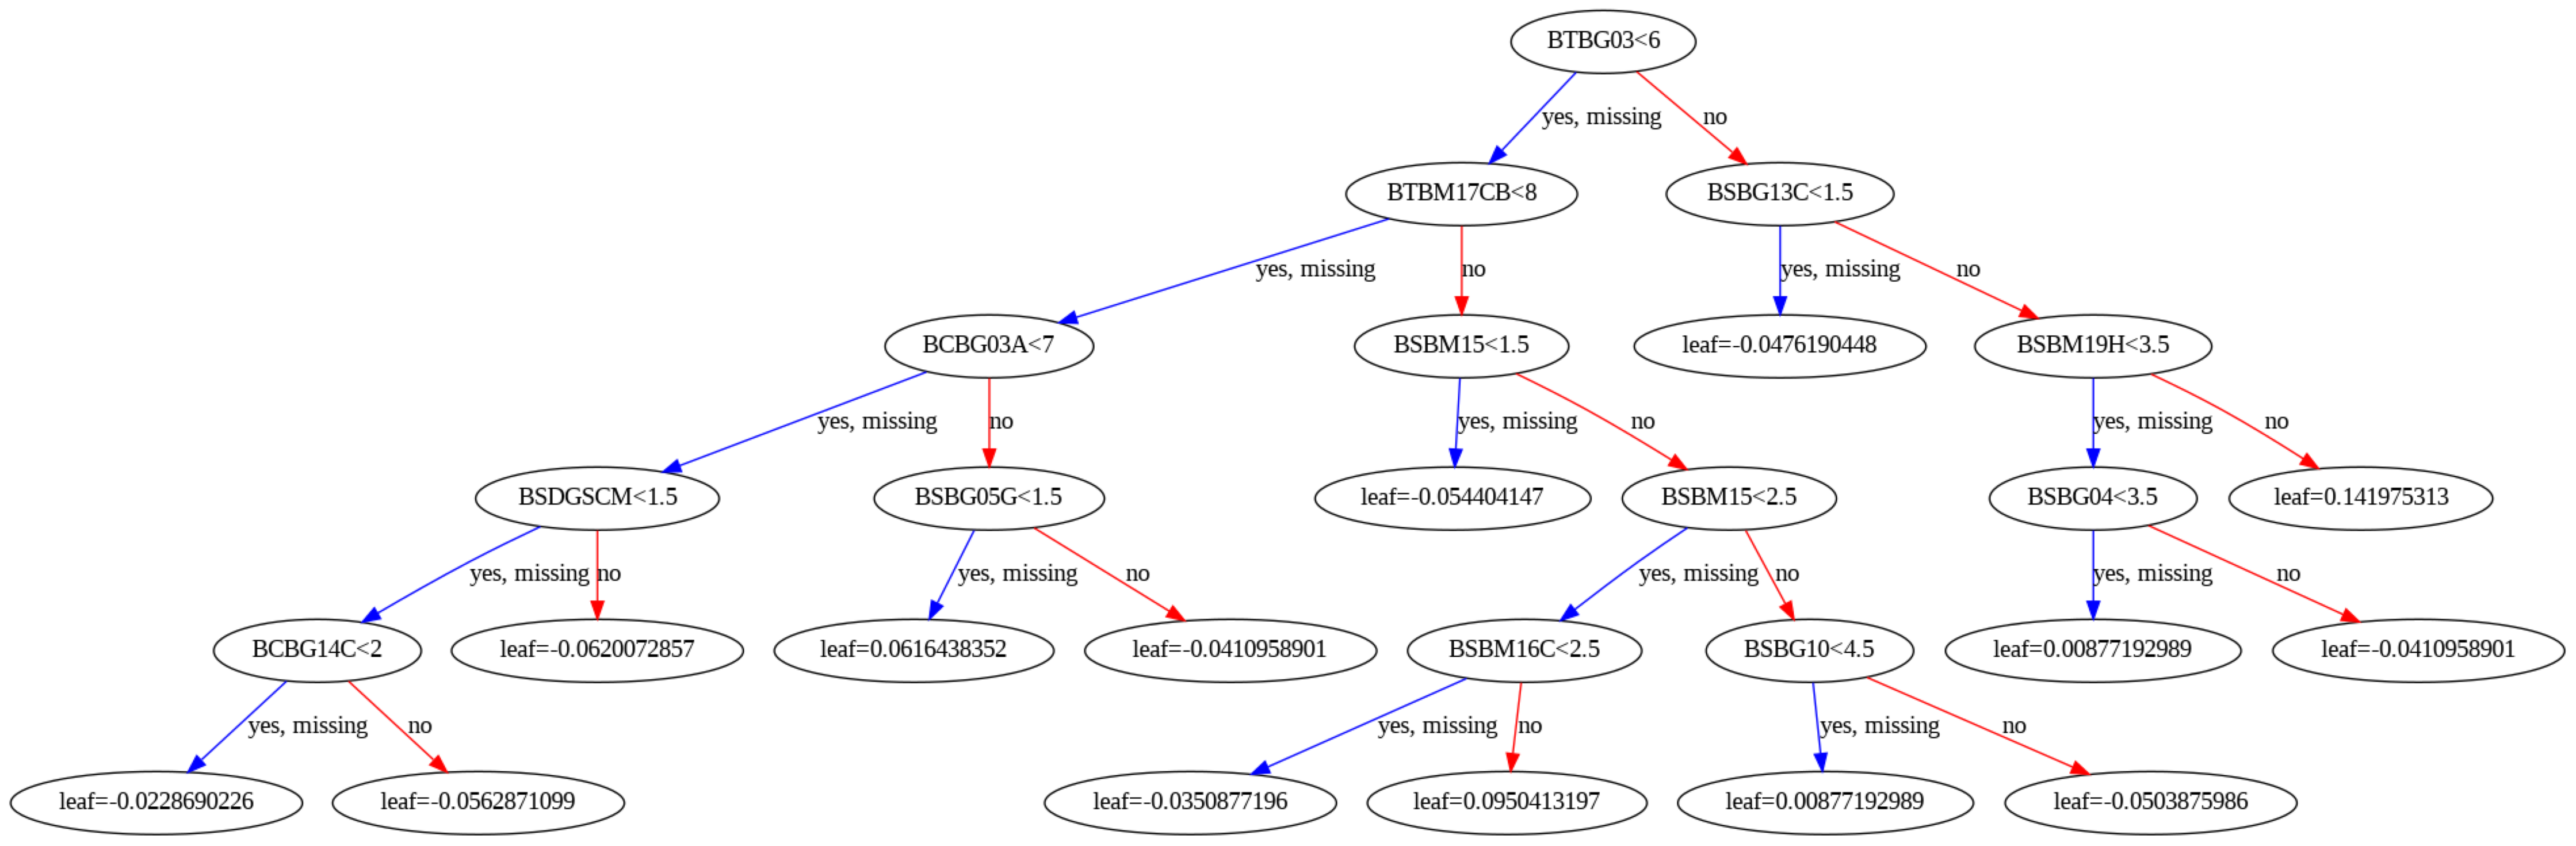


 useful features
          importance
BSDGSCM     0.013262
BSBG05D     0.009165
BTBM17BC    0.009032
BSBM19H     0.008815
BCBG05B     0.007505
BSBM19B     0.007456
BCBG04      0.006898
BSBM19D     0.006763
BSDGEDUP    0.006670
BCBG05A     0.006583
BTBM22BA    0.006484
BTBG07D     0.006186
BTBM18DF    0.006130
BCBG14F     0.006074
BSBG07      0.005841
BTBG09A     0.005777
BTBM15F     0.005771
BSBG04      0.005577
BTBG07A     0.005412
BSBM19A     0.005299
BTBG08B     0.005161
BTBG05F     0.005074
BCBG17A     0.005052
BTBG06F     0.004956
BCBG14E     0.004835
BTBG07C     0.004763
BCBG14H     0.004733
BTBM22BG    0.004665
BTBG06J     0.004643
BCBG15H     0.004632


In [112]:
not_uniques, best_attributes = xgbClassifier(female_df,'finalscore', ['finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'])
                                                       
female_df = female_df[['finalscore'] + best_attributes + not_uniques]

In [113]:
spr_corr(female_df, 'finalscore')

[('BSDGSCM', -0.3805800139149065),
 ('BSBM19D', -0.3340584138079689),
 ('BSBM19A', -0.3255525902370413),
 ('BSDGEDUP', -0.3104149450081421),
 ('BSBG05D', -0.21340263874573212),
 ('BCBG05B', -0.21325511696895166),
 ('BCBG14H', -0.20309377115364632),
 ('BCBG05A', -0.1919273317611051),
 ('BTBG06J', -0.1846943149559997),
 ('BCBG04', -0.18130818098059637),
 ('BTBG06F', -0.18090826180353473),
 ('BCBG14F', -0.16417567713137718),
 ('BTBG07C', -0.15105452054217136),
 ('BTBG07D', -0.1504980148664748),
 ('BTBG07A', -0.12335797091853162),
 ('BCBG17A', -0.10172865214639622),
 ('BCBG15H', -0.09948937748213763),
 ('BCBG14E', -0.09752507666657255),
 ('BTBG05F', -0.09133716348292455),
 ('BTBM17BC', -0.08655482468383685),
 ('BTBG11', -0.07214292325438827),
 ('BTBG08B', -0.05740751956931462),
 ('BSDAGE', -0.036844561980942256),
 ('BTBM22BG', -0.018265547241700025),
 ('BTBM22BA', -0.013385928132480199),
 ('BTDMDAT', 0.0026923156422840296),
 ('BSBGSSB', 0.006015651444583867),
 ('BTDMALG', 0.025355225724310


 correlation of finalscore and BSBM19H : 


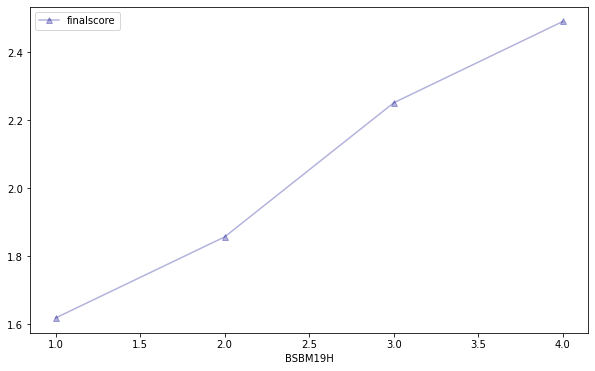


 correlation of finalscore and BSBM19A : 


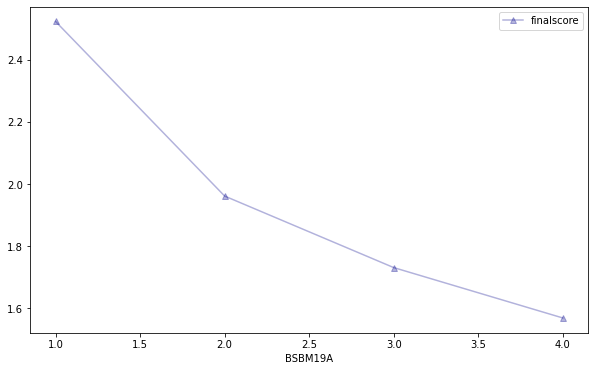


 correlation of finalscore and BSBM19B : 


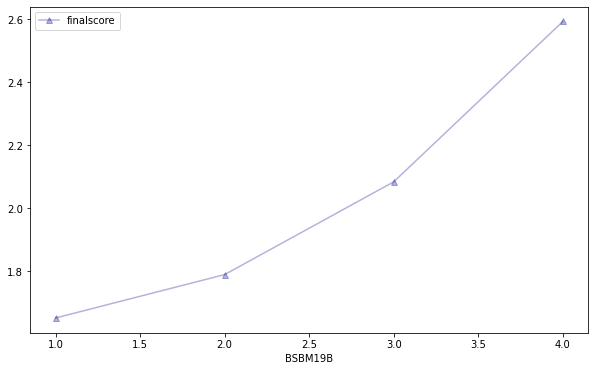

In [114]:
show_corr(female_df, 'BSBM19H', 'finalscore')
show_corr(female_df, 'BSBM19A', 'finalscore')
show_corr(female_df, 'BSBM19B', 'finalscore')

MATH\AGREE\MATHEMATICS HARDER FOR ME :direct relationship

MATH\AGREE\USUALLY DO WELL IN MATH :inverse relationship

MATH\AGREE\MATHEMATICS IS MORE DIFFICULT :direct relationship





###Male

In [115]:
male_df = clean_df[clean_df['BSBG01']==2]
male_df

finalscore  finalscorealgebra  finalscoredat  finalscoregeo  \
5            1.0                2.0            2.0            1.0   
6            1.0                1.0            2.0            1.0   
7            2.0                2.0            1.0            1.0   
11           1.0                2.0            2.0            1.0   
12           2.0                2.0            1.0            1.0   
...          ...                ...            ...            ...   
5971         4.0                4.0            3.0            3.0   
5972         3.0                3.0            2.0            4.0   
5975         2.0                2.0            2.0            2.0   
5978         2.0                1.0            1.0            3.0   
5979         1.0                1.0            2.0            1.0   

      finalscorenum  BSBG01  BSBG03  BSBG04  BSBG05A  BSBG05B  ...  BTBM23  \
5               1.0     2.0     4.0     3.0      2.0      2.0  ...       2   
6               1.0     2.0     4.0     2.0      1.0      1.0  ...       3   
7               2.0     2.0     1.0     2.0      1.0      2.0  ...       3   
11              1.0     2.0     2.0     1.0      1.0      1.0  ...       4   
12              2.0     2.0     3.0     3.0      1.0      2.0  ...       4   
...             ...     ...     ...     ...      ...      ...  ...     ...   
5971            2.0     2.0     1.0     2.0      1.0      2.0  ...       2   
5972            2.0     2.0     1.0     3.0      1.0      1.0  ...       2   
5975            2.0     2.0     2.0     2.0      2.0      2.0  ...       2   
5978            1.0     2.0     1.0     5.0      1.0      1.0  ...       4   
5979            1.0     2.0     3.0     5.0      2.0      1.0  ...       4   

      BTDGEAS  BTDGLSN  BTDGSOS  BTDGTJS  BTDMMME  BTDMNUM   BTDMALG  \
5           3        1        1        2        4    100.0  28.57143   
6           3        2        3        1        4    100.0  42.85714   
7           3        2        3        1        4    100.0  42.85714   
11          3        1        1        2        2    100.0  42.85714   
12          3        1        1        2        2    100.0  42.85714   
...       ...      ...      ...      ...      ...      ...       ...   
5971        2        2        2        1        2    100.0  42.85714   
5972        2        2        2        1        2    100.0  42.85714   
5975        3        3        1        1        2    100.0  28.57143   
5978        3        3        2        3        2    100.0  14.28571   
5979        3        3        2        3        2    100.0  14.28571   

        BTDMGEO    BTDMDAT  
5     100.00000   83.33333  
6      83.33333  100.00000  
7      83.33333  100.00000  
11     83.33333  100.00000  
12     83.33333  100.00000  
...         ...        ...  
5971  100.00000   50.00000  
5972  100.00000   50.00000  
5975  100.00000   83.33333  
5978   83.33333   66.66667  
5979   83.33333   66.66667  

[3004 rows x 327 columns]

In [116]:
not_uniques, best_attributes = xgbClassifier(male_df,'finalscore', ['finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'] )
                                                       
male_df = male_df[['finalscore'] + best_attributes + not_uniques]

BTDMDAT     8
BCBG05A     8
BSDGEDUP    7
BSBM42BA    7
BSBG07      7
           ..
BTBG02      2
BTBG05A     2
BTBG05F     2
ITSEX       1
BSBG01      1
Length: 300, dtype: int64

 useful features
          importance
BCBG14H     0.015946
BCDGSBC     0.015387
BCDGEAS     0.013418
BSBG07      0.012610
BTBM20A     0.012124
BSBG05B     0.009875
BCBG05A     0.009609
BTBG06G     0.008205
BTBG06F     0.008173
BCBG13AA    0.007826
BTDMNUM     0.007808
BCBG16A     0.007423
BCBG09      0.006747
BCBG08B     0.006680
BTBG13A     0.006086
BTBM18CD    0.005724
BTBM18DF    0.005610
BSBM19B     0.005407
BTBM18DD    0.005379
BTBG07D     0.005337
BSDGSCM     0.005332
BSBG04      0.005320
BTBM17BA    0.005278
BCBG21A     0.005192
BTBM18BB    0.005185
BCBG06C     0.005126
BCBG04      0.005126
BCBG15B     0.005118
BCBG03A     0.005104
BCBG14D     0.005015


In [117]:
spr_corr(male_df, 'finalscore')

[('BCDGSBC', -0.34786711675978027),
 ('BSDGSCM', -0.3430926801790727),
 ('BCBG05A', -0.3201854513396562),
 ('BTBG06G', -0.2966372852645241),
 ('BCBG03A', -0.2918405894900196),
 ('BCBG14H', -0.29141072090568765),
 ('BTBG06F', -0.28259353678660165),
 ('BSBG05B', -0.2734299336163333),
 ('BCDGEAS', -0.25948416873460844),
 ('BCBG09', -0.245763028916013),
 ('BCBG15B', -0.22524339321052592),
 ('BCBG16A', -0.21097308725412622),
 ('BCBG04', -0.18040918043466198),
 ('BTBG13A', -0.14547627871186716),
 ('BTBG11', -0.13780550177956752),
 ('BCBG08B', -0.12268575255278287),
 ('BCBG14D', -0.11872459626654494),
 ('BCBG06C', -0.10983219489944476),
 ('BTBG07D', -0.08364177618208507),
 ('BSDAGE', -0.07499706708984934),
 ('BTBM17BA', -0.06627473690381365),
 ('BCBG13AA', -0.06203140006734116),
 ('BCBG19', -0.03385287686785268),
 ('BTBM18CD', -0.022706881529241635),
 ('BTDMALG', -0.008708612837204102),
 ('BCBG18', 0.01903551353125133),
 ('BTBM18DD', 0.021205715794824935),
 ('BTBM18BB', 0.025693898860651463),


 correlation of finalscore and BSBGSCM : 


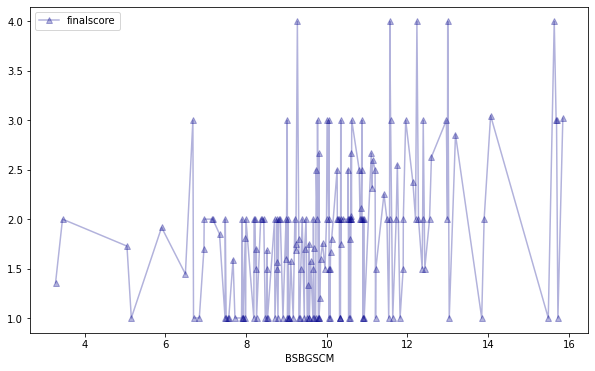


 correlation of finalscore and BSBGHER : 


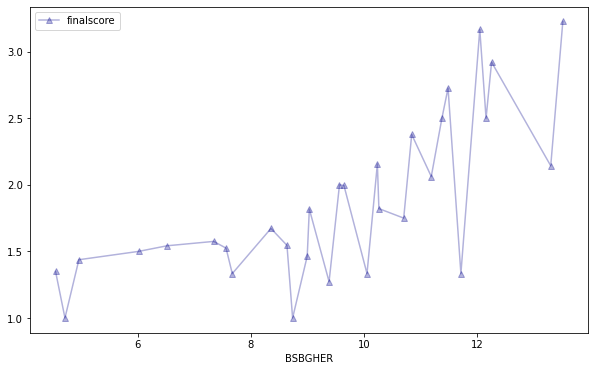


 correlation of finalscore and BCDGSBC : 


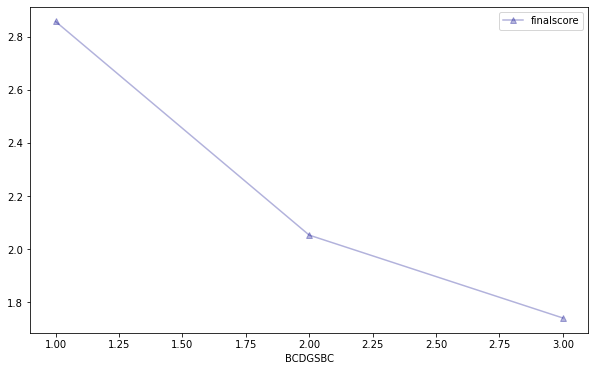

In [118]:
show_corr(male_df, 'BSBGSCM', 'finalscore')
show_corr(male_df, 'BSBGHER', 'finalscore')
show_corr(male_df, 'BCDGSBC', 'finalscore')

first plot :GEN\AMOUNT OF BOOKS IN YOUR HOME: direct relationship

second plot :GEN\STUDENTS BACKGROUND\ECONOMIC AFFLUEN :direct relationship
 
third plot :GEN\HOW MANY PEOPLE LIVE IN AREA :inverse relationship


We can see that the underlying factors have acted somewhat differently in the two sexes. Of course, in both cases, these features were among many dependencies, but their amount is slightly different. For example, the amount of resources at home is more important for boys, and for girls, self-confidence in dealing with mathematics and the speed of learning it are more important.
so we assumed that gender is important in some features and not in some of them.


#Effects on other final scores

In this section, similar to the first section, we only go through the same process 4 times for the 4 destination columns to account for each content.

###Algebra

BTDMGEO     8
BCBG05A     8
BSBM26BA    7
BSBM42BA    7
BSDGEDUP    7
           ..
BTBG05G     2
ITSEX       2
BCBG12      2
BTBG02      2
BSBG01      2
Length: 299, dtype: int64


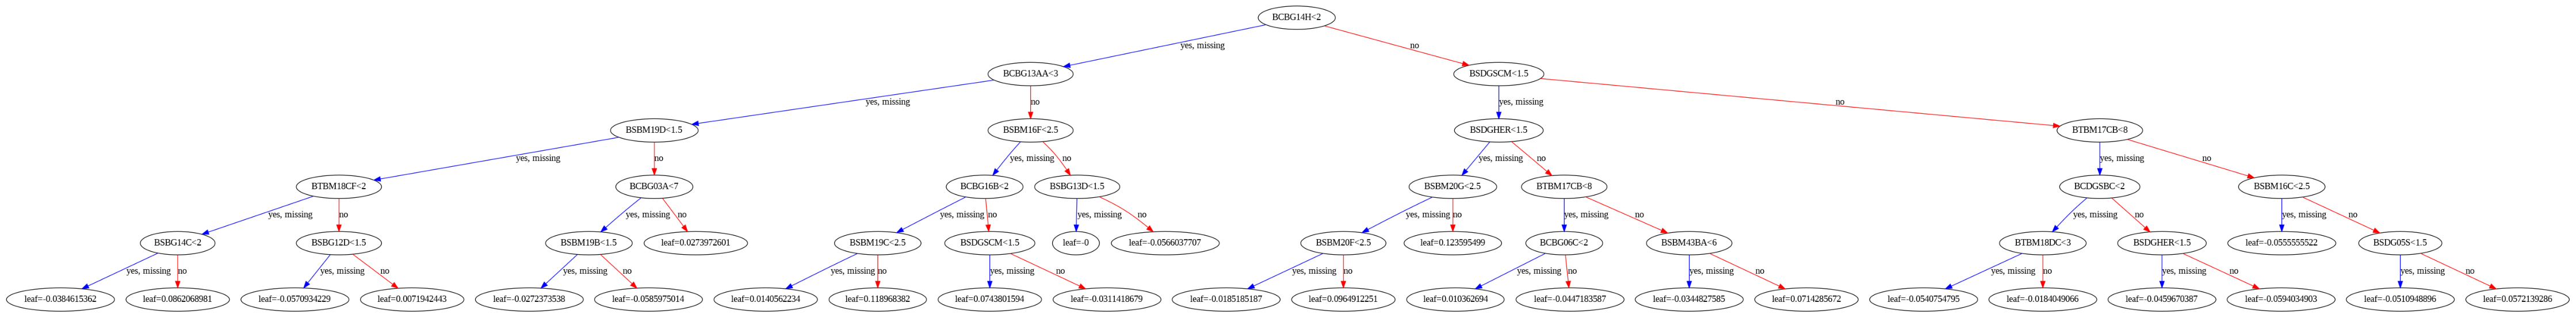


 useful features
          importance
BSDGSCM     0.016302
BSBG07      0.010829
BCBG14H     0.010187
BCBG05B     0.009252
BSDGEDUP    0.007181
BCDGDAS     0.006666
BCBG05A     0.006399
BSBM19B     0.006379
BCBG14I     0.006021
BTBG02      0.005798
BCBG16E     0.005658
BTBG06F     0.005642
BSBG05B     0.005531
BCBG04      0.005436
BSBG08A     0.005423
BTBM17BB    0.005400
BCBG03B     0.005350
BCBG14G     0.005143
BSBG01      0.004900
BCBG03A     0.004874
BTBM19CE    0.004821
BCBG14F     0.004817
BSBM19H     0.004684
BSBM19A     0.004649
BTBG06B     0.004556
BTBG12G     0.004486
BTBG12A     0.004477
BTBG07C     0.004428
BTBG09A     0.004404
BCBG13BC    0.004389


In [119]:
not_uniques, best_attributes = xgbClassifier(clean_df,'finalscorealgebra', ['finalscore', 'finalscoredat',	'finalscoregeo', 'finalscorenum'] )                 
                                                
algebra_df = clean_df[['finalscorealgebra'] + best_attributes + not_uniques]



In [120]:
spr_corr(algebra_df, 'finalscorealgebra')

[('BSDGSCM', -0.29707051943533325),
 ('BSDGEDUP', -0.26147461089763846),
 ('BSBM19A', -0.2351959545118594),
 ('BCBG05B', -0.22586822798826786),
 ('BCBG05A', -0.21979340199233174),
 ('BCBG14H', -0.2170524825419395),
 ('BCBG14F', -0.2157287090498767),
 ('BTBG06F', -0.1983240765064411),
 ('BSBG05B', -0.19097941088073422),
 ('BCBG14G', -0.18702801673818578),
 ('BCBG03A', -0.18314880581964446),
 ('BCBG14I', -0.1721212006047893),
 ('BCBG16E', -0.15181050928734835),
 ('BCBG04', -0.15084571619041326),
 ('BCDGDAS', -0.1447111502031506),
 ('BTBG07C', -0.12196792649322581),
 ('BTBG06B', -0.09387348151846045),
 ('BSBG08A', -0.0908371844105801),
 ('BTBG11', -0.08799148193233831),
 ('BCBG13BC', -0.08369646749834068),
 ('BTBG02', -0.07672481872642742),
 ('BTBM17BB', -0.07275008599196336),
 ('BSBG01', -0.0723311071043739),
 ('BSDAGE', -0.061038354127215026),
 ('BTBG12G', -0.053565248905273095),
 ('BTBG12A', -0.0425171141041451),
 ('BTDMDAT', 0.00377385289991637),
 ('BTDMALG', 0.007545417215401382),
 (


 correlation of finalscorealgebra and BSBM19H : 


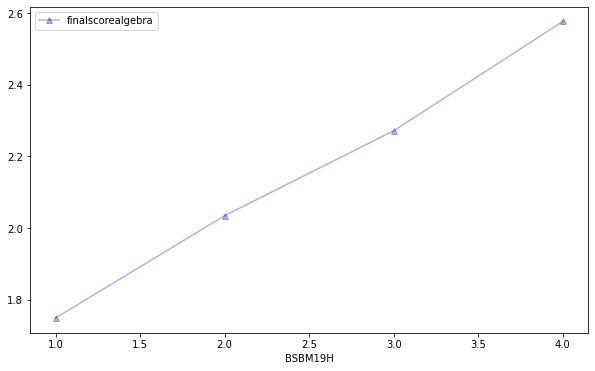


 correlation of finalscorealgebra and BSDGSCM : 


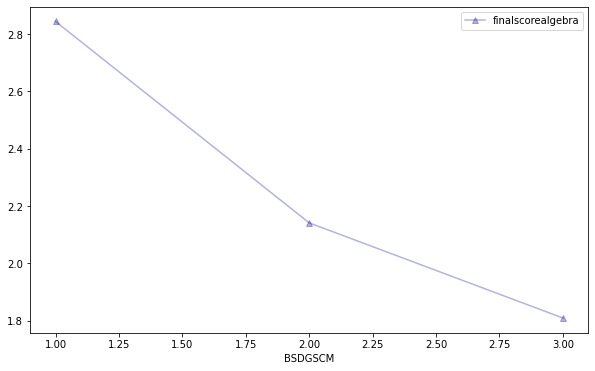


 correlation of finalscorealgebra and BSDGEDUP : 


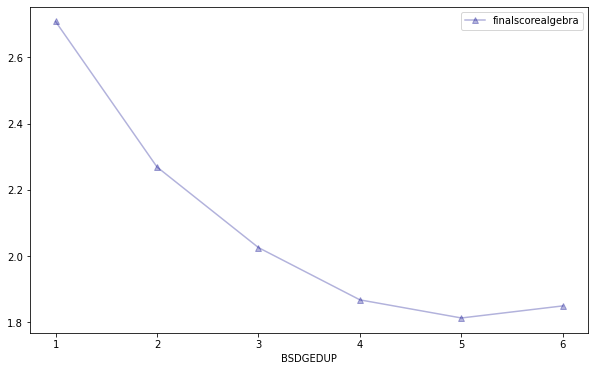

In [121]:
show_corr(algebra_df, 'BSBM19H', 'finalscorealgebra')
show_corr(algebra_df, 'BSDGSCM', 'finalscorealgebra')
show_corr(algebra_df, 'BSDGEDUP', 'finalscorealgebra')

###Datas

BTDMGEO     8
BCBG05A     8
BSBM26BA    7
BSBM42BA    7
BSDGEDUP    7
           ..
BTBG05G     2
ITSEX       2
BCBG12      2
BTBG02      2
BSBG01      2
Length: 299, dtype: int64


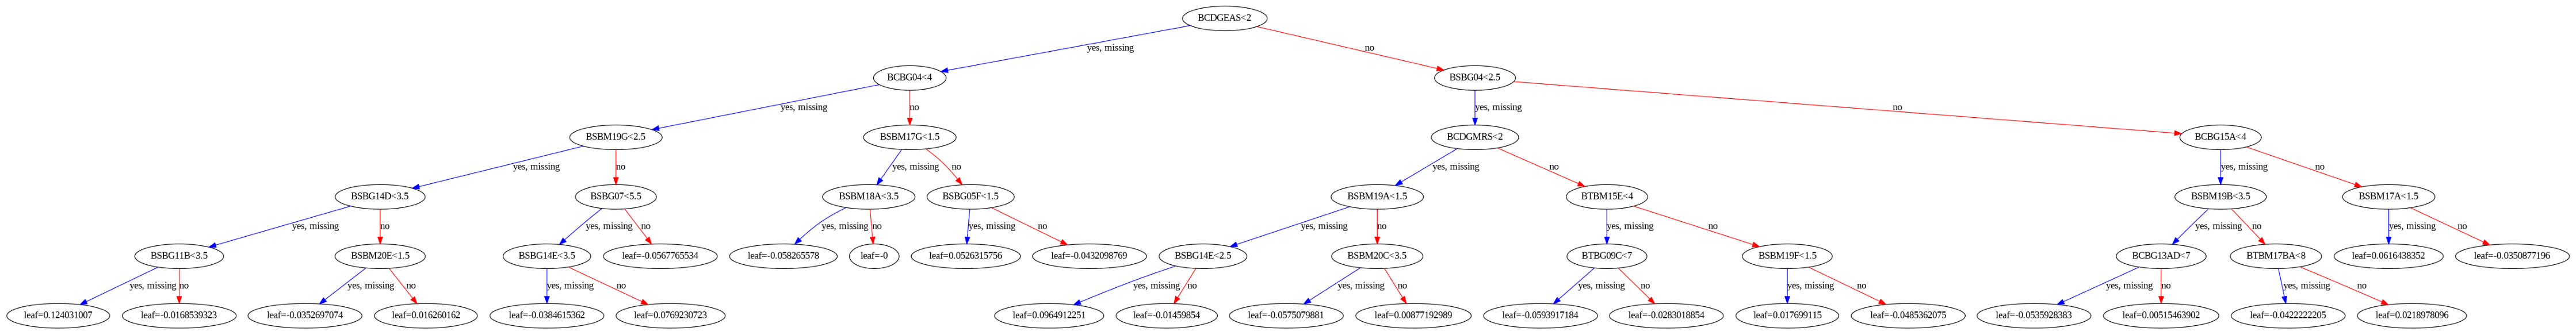


 useful features
          importance
BSBG07      0.009240
BCDGEAS     0.008184
BSDGSCM     0.007709
BSBG05D     0.007273
BSBM19H     0.006922
BTBG08E     0.006097
BCBG05B     0.005617
BTBM17CB    0.005454
BTBG05H     0.005413
BTBM18CD    0.004905
BSBG04      0.004901
BTBM17BC    0.004863
BSBM19B     0.004843
BTBG12E     0.004817
BCBG16C     0.004782
BSBM43BA    0.004755
BTBM22BC    0.004743
BCBG05A     0.004683
BTBM18AB    0.004680
BCBG14H     0.004606
BTBG13H     0.004561
BTBM20A     0.004525
BTBM18DD    0.004503
BCBG15D     0.004498
BTBM17BB    0.004481
BTBM22BE    0.004390
BTBG06J     0.004378
BCBG16E     0.004354
BTBM17A     0.004348
BTBM18CA    0.004277


In [122]:
not_uniques, best_attributes = xgbClassifier(clean_df, 'finalscoredat', ['finalscore', 'finalscorealgebra',	'finalscoregeo', 'finalscorenum']  )
                                                      
dat_df = clean_df[['finalscoredat'] + best_attributes + not_uniques]



In [123]:
spr_corr(dat_df, 'finalscoredat')

[('BSDGSCM', -0.21083277129095435),
 ('BCBG05B', -0.17348613535543178),
 ('BCBG14H', -0.16272018157588242),
 ('BCBG05A', -0.1577582949216187),
 ('BSBG05D', -0.1383289176694199),
 ('BCDGEAS', -0.13607953861103894),
 ('BTBG06J', -0.11015433263046133),
 ('BCBG16E', -0.0886110860755978),
 ('BTBG13H', -0.08053132826344747),
 ('BCBG16C', -0.07982239521092581),
 ('BTBG11', -0.07704141944338025),
 ('BCBG15D', -0.07422205902692403),
 ('BSBM43BA', -0.0704389256962148),
 ('BTBM17BB', -0.06045524269549703),
 ('BTBM17A', -0.056955728966172445),
 ('BTBG12E', -0.0544642453751819),
 ('BTBM17BC', -0.050594837566815265),
 ('BTBG05H', -0.030423389245749614),
 ('BTBM17CB', -0.029440772617406626),
 ('BTBM18CD', -0.02439070133044846),
 ('BSDAGE', -0.022918246448325123),
 ('BTBG08E', -0.01211167610041468),
 ('BTBM18DD', -0.00922740106682074),
 ('BSBGSSB', -0.001079166297877422),
 ('BTBM22BE', 0.00932779711277174),
 ('BTBM18CA', 0.009341435149479887),
 ('BTDMDAT', 0.00970216172172095),
 ('BTDMALG', 0.01012616


 correlation of finalscoredat and BSBM19B : 


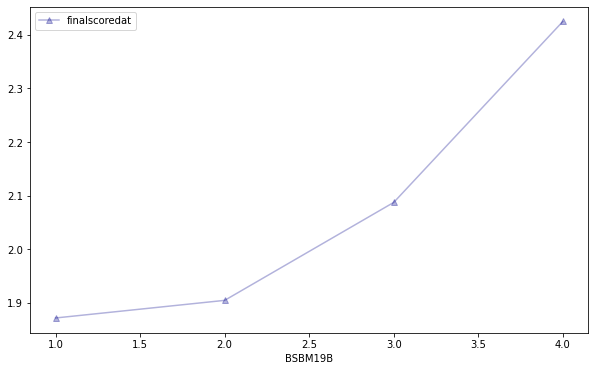


 correlation of finalscoredat and BSBG04 : 


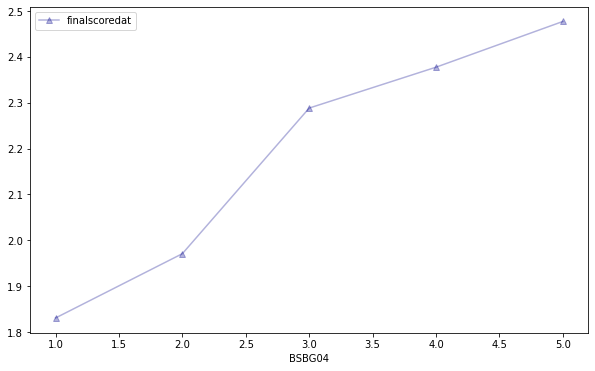


 correlation of finalscoredat and BSBM19H : 


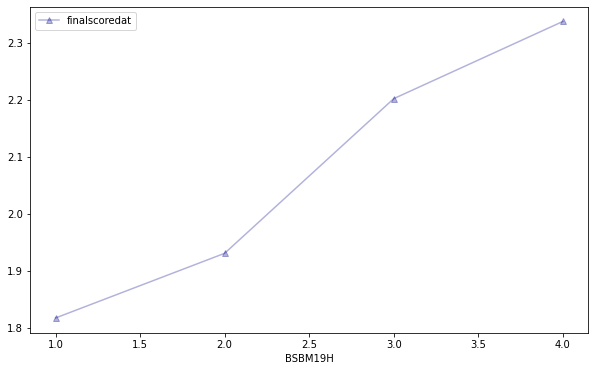

In [124]:
show_corr(dat_df, 'BSBM19B', 'finalscoredat')
show_corr(dat_df, 'BSBG04', 'finalscoredat')
show_corr(dat_df, 'BSBM19H', 'finalscoredat')

###Geometry

BTDMGEO     8
BCBG05A     8
BSBM26BA    7
BSBM42BA    7
BSDGEDUP    7
           ..
BTBG05G     2
ITSEX       2
BCBG12      2
BTBG02      2
BSBG01      2
Length: 299, dtype: int64


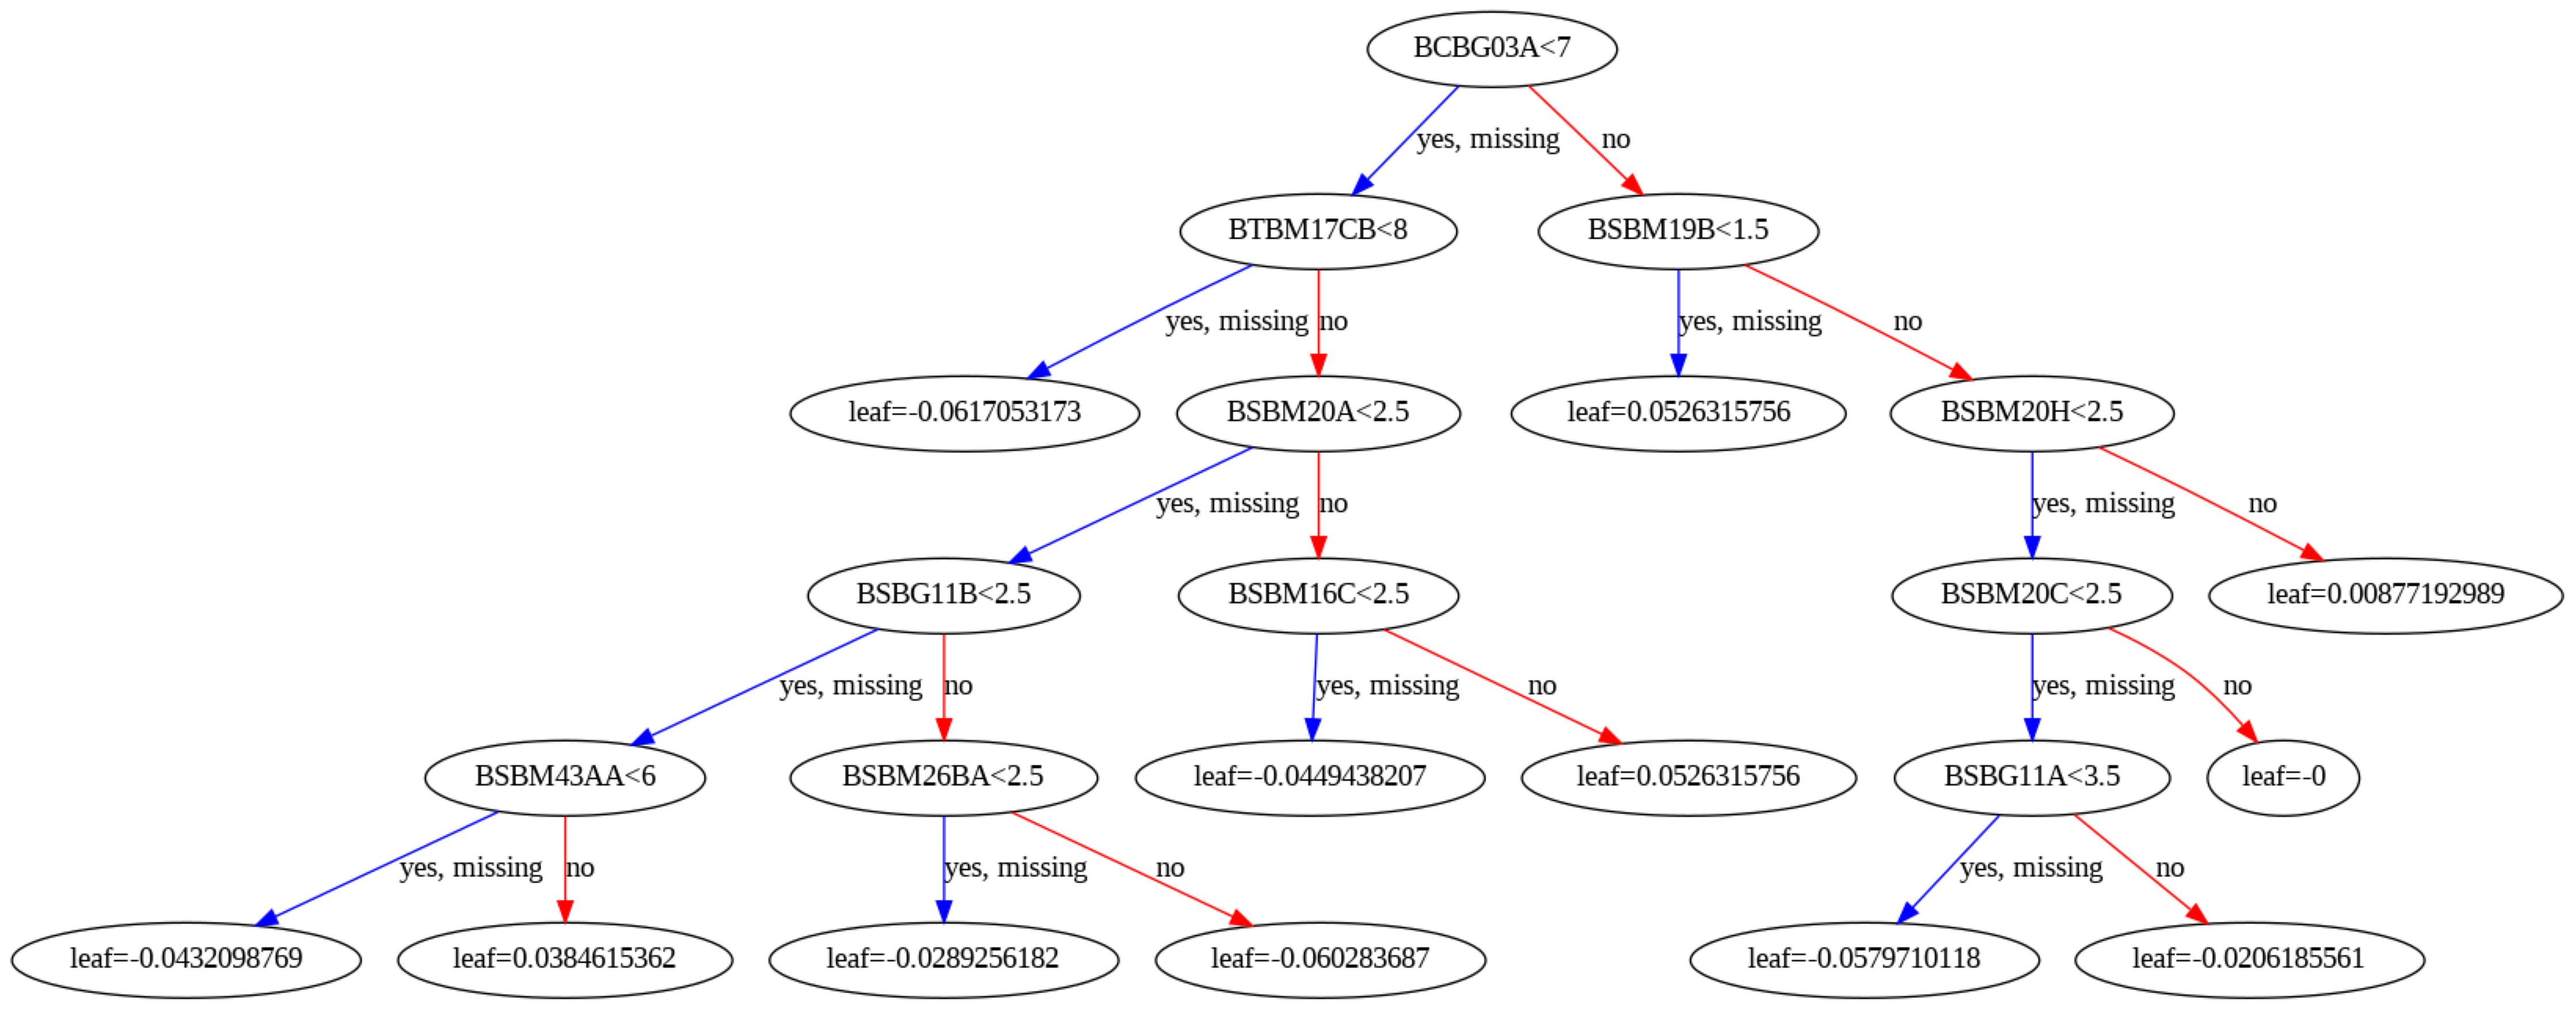


 useful features
          importance
BSDGSCM     0.021884
BSBM19H     0.010967
BCDGSBC     0.009378
BTBG07C     0.008869
BCBG14H     0.007410
BCBG05B     0.007058
BCBG20      0.006894
BCBG14J     0.006426
BSBM19D     0.006343
BCBG09      0.005811
BTBM22AC    0.005713
BCBG03B     0.005611
BTBM18CD    0.005518
BSBG07      0.005465
BCBG14C     0.005463
BCBG05A     0.005392
BTBM18AB    0.005312
BSBM16G     0.005291
BCBG04      0.005283
BSBG05D     0.005222
BTBG06G     0.004834
BCBG15F     0.004760
BTBM18CC    0.004734
BTBG03      0.004683
BTBM18BC    0.004631
BTDMNUM     0.004520
BSBM19B     0.004485
BTBG07G     0.004471
BTBM20A     0.004449
BTBM22AE    0.004409


In [125]:
not_uniques, best_attributes =xgbClassifier(clean_df, 'finalscoregeo', ['finalscore', 'finalscoredat',	'finalscorealgebra', 'finalscorenum'])
                                                  
geo_df = clean_df[['finalscoregeo'] + best_attributes + not_uniques]                                     
                                                       





In [126]:
spr_corr(geo_df, 'finalscoregeo')

[('BSDGSCM', -0.23805721272298846),
 ('BSBM19D', -0.20183191871726236),
 ('BCDGSBC', -0.1769303046922201),
 ('BCBG14J', -0.175408037339635),
 ('BCBG14H', -0.16958234731437602),
 ('BCBG05B', -0.16344321656351127),
 ('BTBG06G', -0.15926381820676347),
 ('BCBG05A', -0.15818675707602814),
 ('BSBM16G', -0.14345054025568962),
 ('BCBG14C', -0.13120570093750883),
 ('BTBG07C', -0.12296993813735352),
 ('BCBG09', -0.11691162758331215),
 ('BSBG05D', -0.11086117836503735),
 ('BCBG04', -0.10520386615642653),
 ('BTBG11', -0.07017021695512518),
 ('BCBG15F', -0.06678088742395315),
 ('BSDAGE', -0.035832570807212305),
 ('BTBM18CC', -0.02891468869341987),
 ('BTBG07G', -0.009568409168813307),
 ('BTBM18CD', -0.0085514982610924),
 ('BTBM22AC', -0.005589260755883871),
 ('BCBG19', 0.0011730750721907568),
 ('BTDMDAT', 0.002179200075663084),
 ('BTDMALG', 0.014937781898978935),
 ('BCBG06A', 0.01532146032733354),
 ('BSBGSSB', 0.020905868467167098),
 ('BTBM18BC', 0.02293518320124211),
 ('BTBM22AE', 0.024521233595404


 correlation of finalscoregeo and BSBGSCM : 


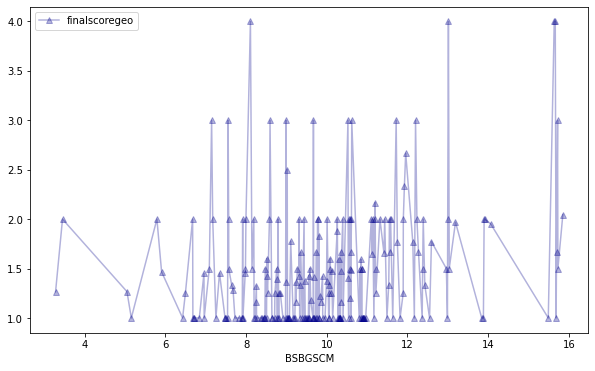


 correlation of finalscoregeo and BSBGHER : 


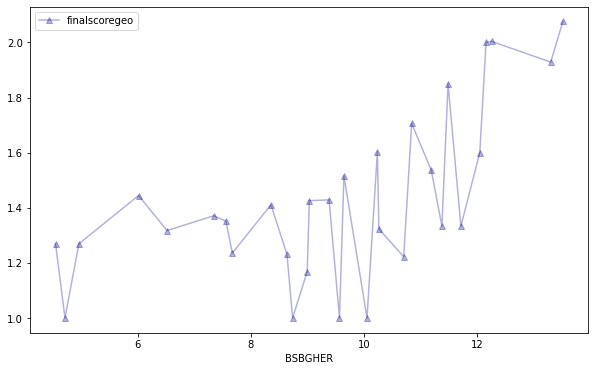


 correlation of finalscoregeo and BSBM19H : 


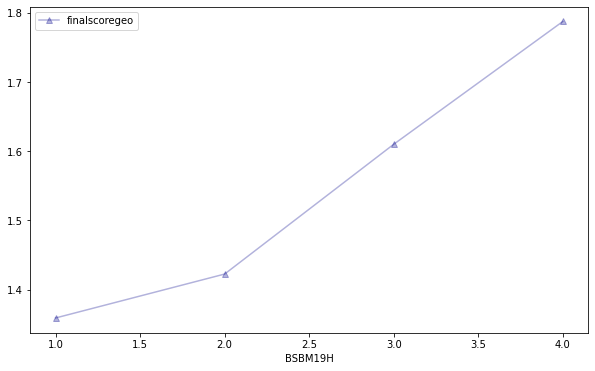

In [127]:
show_corr(geo_df, 'BSBGSCM', 'finalscoregeo')
show_corr(geo_df, 'BSBGHER', 'finalscoregeo')
show_corr(geo_df, 'BSBM19H', 'finalscoregeo')

###Numbers

BTDMGEO     8
BCBG05A     8
BSBM26BA    7
BSBM42BA    7
BSDGEDUP    7
           ..
BTBG05G     2
ITSEX       2
BCBG12      2
BTBG02      2
BSBG01      2
Length: 299, dtype: int64


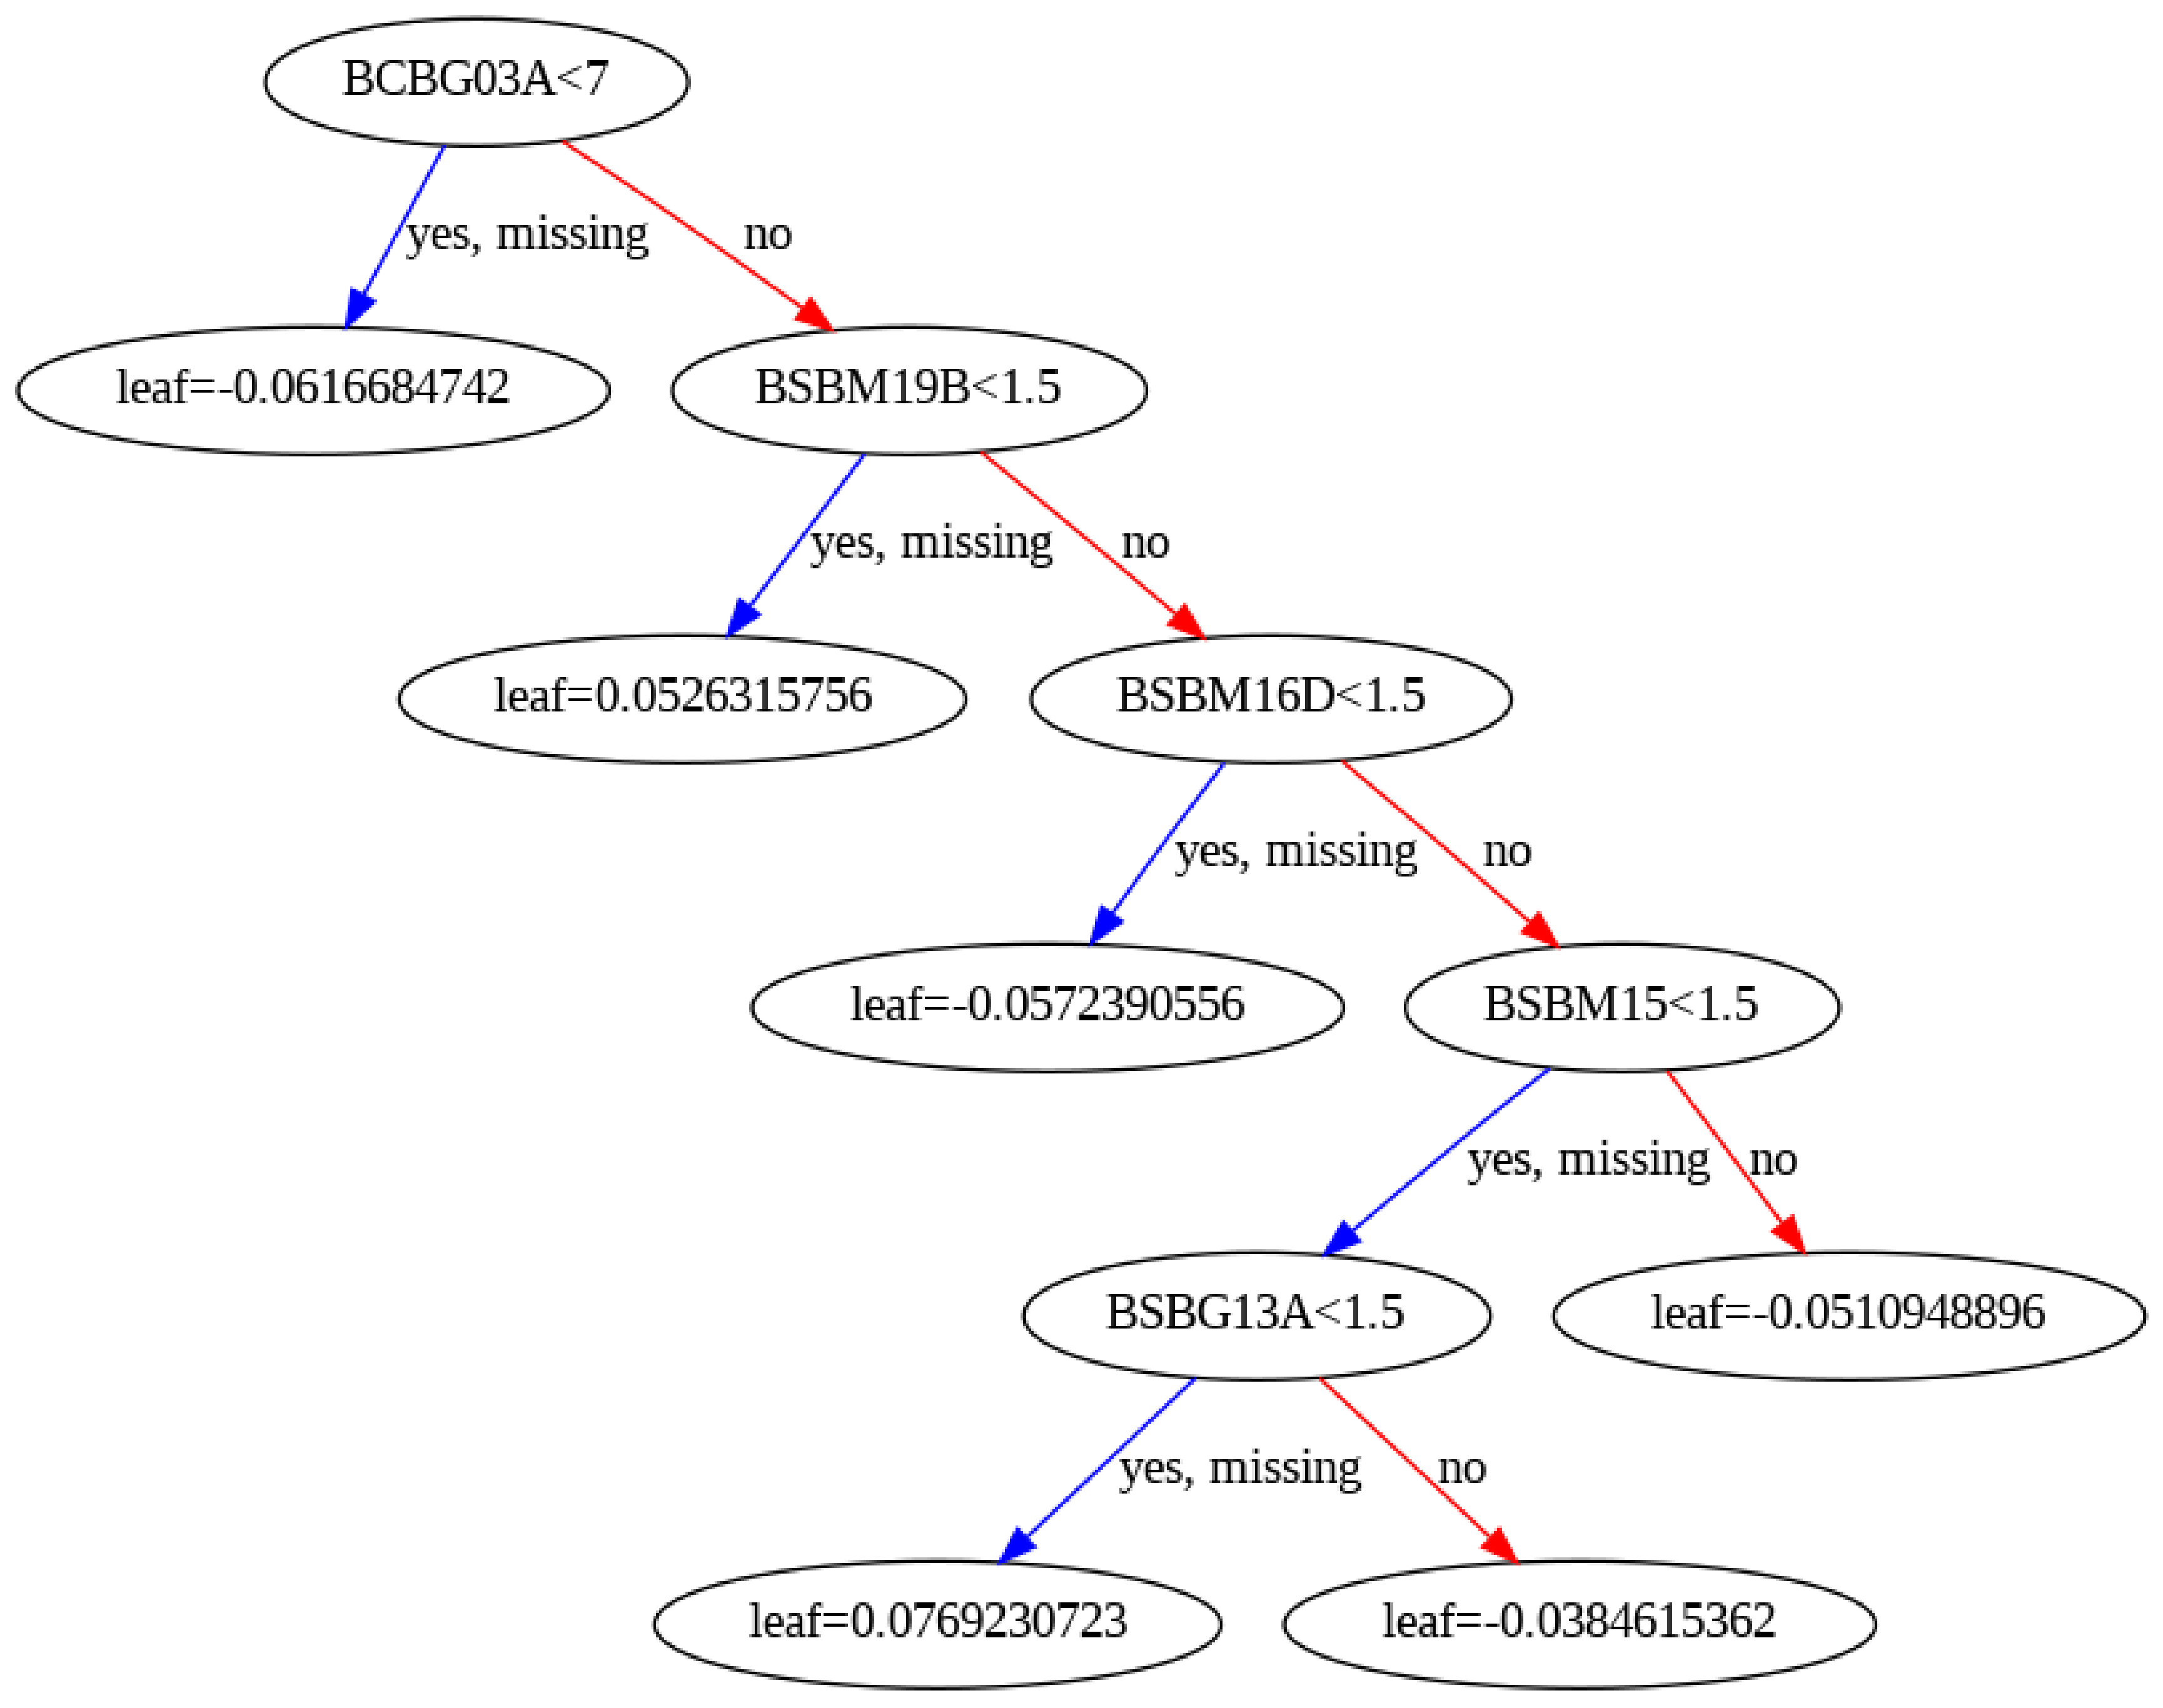


 useful features
          importance
BSDGSCM     0.026236
BCBG16C     0.009582
BCBG05B     0.009363
BSBG05D     0.009121
BSBG04      0.007338
BTDGEAS     0.007038
BCDGSBC     0.006879
BSBM19H     0.006839
BCBG14H     0.006667
BTBM20A     0.006566
BCBG05A     0.006501
BTBG06G     0.006368
BTBM17BC    0.006340
BTBM17A     0.006085
BTBM22AF    0.005995
BCBG04      0.005971
BCBG16F     0.005815
BCBG17B     0.005724
BSBG01      0.005533
BSDGEDUP    0.005409
BSBM19B     0.005405
BTBG06F     0.005394
BTBM18BD    0.005309
BSBG07      0.005305
BSBM19A     0.005233
BCBG03B     0.005204
BSBM19D     0.005150
BTBM22BB    0.005090
BTBM22AG    0.004903
BSBM43BA    0.004820


In [128]:
not_uniques, best_attributes = xgbClassifier(clean_df, 'finalscorenum', ['finalscore', 'finalscoredat',	'finalscoregeo', 'finalscorealgebra'] )
                                                      
num_df = clean_df[['finalscorenum'] + best_attributes + not_uniques]



In [129]:
spr_corr(num_df, 'finalscorenum')

[('BSDGSCM', -0.3034831824979975),
 ('BSDGEDUP', -0.25969695821980787),
 ('BSBM19D', -0.2589473751829097),
 ('BSBM19A', -0.23327362722693237),
 ('BCDGSBC', -0.21281119345562902),
 ('BCBG05B', -0.20991608861266192),
 ('BCBG14H', -0.20243646833486872),
 ('BTBG06G', -0.20032844280085696),
 ('BCBG05A', -0.19314262472025584),
 ('BTBG06F', -0.18975359783161366),
 ('BSBG05D', -0.16868782810802804),
 ('BTDGEAS', -0.1660469063332672),
 ('BCBG04', -0.13070207156187308),
 ('BCBG16C', -0.11779966933034672),
 ('BSBM43BA', -0.10538308174250798),
 ('BCBG16F', -0.09851502663075289),
 ('BTBG11', -0.09034270278414841),
 ('BTBM17A', -0.08898444214701595),
 ('BTBM17BC', -0.08693361279050968),
 ('BCBG17B', -0.05808692293868888),
 ('BSDAGE', -0.04702863495644544),
 ('BCBG19', 0.008758020308213791),
 ('BTDMALG', 0.0121190919723477),
 ('BTDMDAT', 0.012463801492287981),
 ('BTBM22BB', 0.01450164305296938),
 ('BSBG01', 0.019219110086366106),
 ('BSBGSSB', 0.021600862188056773),
 ('BCBG06A', 0.028889307306221308),


 correlation of finalscorenum and BSBG04 : 


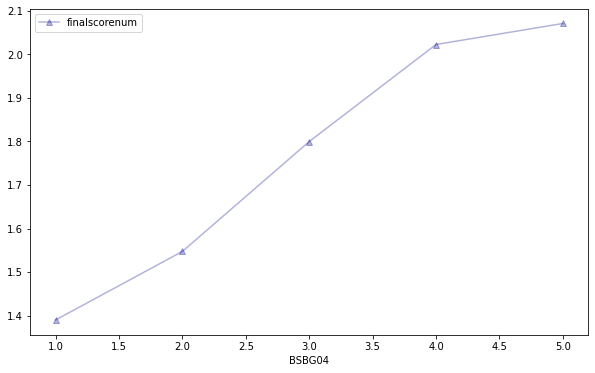


 correlation of finalscorenum and BSDGEDUP : 


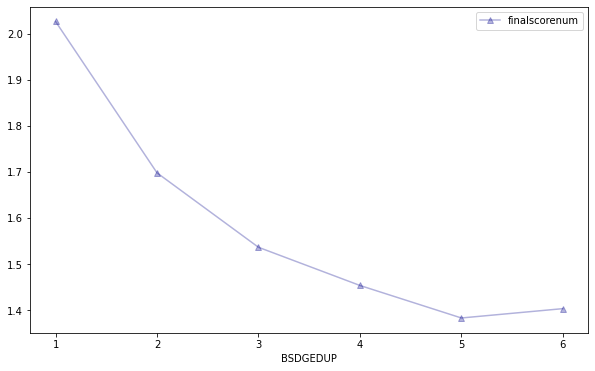


 correlation of finalscorenum and BSBM19H : 


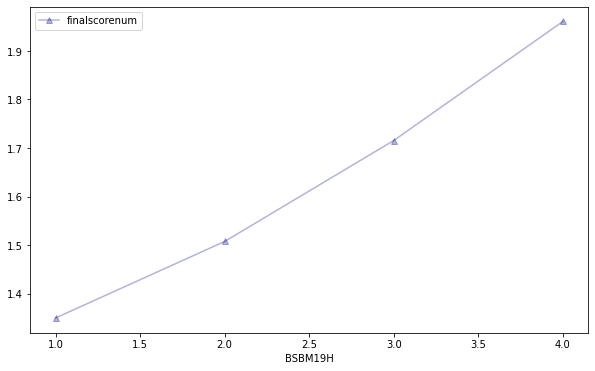

In [130]:
show_corr(num_df, 'BSBG04', 'finalscorenum')
show_corr(num_df, 'BSDGEDUP', 'finalscorenum')
show_corr(num_df, 'BSBM19H', 'finalscorenum')

For each of the columns, the three variables that have been highly dependent are as follows:

 algebra: BSBM19H : direct , BSDGEDUP : inverse , BSBG04 : direct

 datas: BSBM19B : direct , BSBG04 : direct , BSBM19H : direct

 geometry: BSDGEDUP : direct , BSBM19B : inverse , BSBM19H : direct

 numbers: BSBG04 : direct , BSDGEDUP: inverse , BSBM19H : direct

We see that the criteria are slightly different. And the correlation coefficients sometimes have significant differences between different content areas.